In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Built-in
import os
from pathlib import Path
import time

# External
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [3]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/applicabilityDomain


In [4]:
file_idx_train = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_train.csv")
file_idx_test = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_test.csv")

idx_train = pd.read_csv(file_idx_train, dtype=pd.Int64Dtype())
idx_test = pd.read_csv(file_idx_test, dtype=pd.Int64Dtype())

# Selecting only 1 CV set
col = idx_train.columns[0]
idx_test = idx_test[col].dropna(axis=0).to_numpy().astype(int)
idx_train = idx_train[col].dropna(axis=0).to_numpy().astype(int)

print(len(idx_test) + len(idx_train))

6506


In [5]:
# Load labels
file_smiles = os.path.join(PATH_ROOT, "data", "smiles", "Ames_smiles.csv")
df = pd.read_csv(file_smiles)
y = df['y'].to_numpy()

print(y.shape)

(6506,)


In [6]:
# Load data
X = {}
file_maccs = os.path.join(PATH_ROOT, "data", "maccs", "Ames_maccs.npy")
X['maccs'] = np.load(file_maccs)
print('maccs:', X['maccs'].shape)

maccs: (6506, 167)


In [7]:
file_cddd = os.path.join(PATH_ROOT, "data", "cddd", "Ames_cddd.npy")
X['cddd'] = np.load(file_cddd)
print('cddd:', X['cddd'].shape)

cddd: (6506, 512)


In [8]:
file_ecfp = os.path.join(PATH_ROOT, "data", "ecfp", "Ames_ecfp.npy")
X['ecfp'] = np.load(file_ecfp)
print('ecfp:', X['ecfp'].shape)

ecfp: (6506, 1024)


In [9]:
file_rdkit = os.path.join(PATH_ROOT, "data", "rdkit", "Ames_rdkit.npy")
X['rdkit'] = np.load(file_rdkit)
print('rdkit:', X['rdkit'].shape)

rdkit: (6506, 2048)


In [10]:
DESCRIPTORS = ['maccs', 'cddd', 'ecfp', 'rdkit']
Xs_train, Xs_test = [], []

for des in DESCRIPTORS:
    Xs_train.append(X[des][idx_train])
    Xs_test.append(X[des][idx_test])

y_train = y[idx_train]
y_test = y[idx_test]

In [11]:
clf = RandomForestClassifier(n_estimators=200)
clf.fit(Xs_train[0], y_train)
acc_train = clf.score(Xs_train[0], y_train)
print(f'Train score: {acc_train * 100:.2f}%')
acc_test = clf.score(Xs_test[0], y_test)
print(f'Test score: {acc_test * 100:.2f}%')


Train score: 97.77%
Test score: 79.57%


In [12]:
from adad.adversarial.feature_squeezing import SklearnFeatureSqueezing

In [13]:
# Each classifier has its own parameters
clf_params = [{'n_estimators':200}] * (len(DESCRIPTORS)-1)
fs = SklearnFeatureSqueezing(clf, RandomForestClassifier, len(DESCRIPTORS)-1, clf_params)
fs.fit(Xs_train[1:], y=y_train)

In [14]:
dm = fs.measure(Xs_test[0], Xs_test[1:])

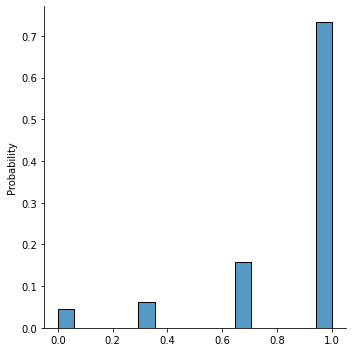

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(dm, stat='probability')
plt.show()

In [16]:
from sklearn.metrics import auc, RocCurveDisplay

from adad.evaluate import permutation_auc, roc_ad

In [17]:
dm = 1. / (dm + 1e-6)

In [18]:

y_pred = clf.predict(Xs_test[0])
perm_auc, _ = permutation_auc(y_test, y_pred, dm)
print(perm_auc)

0.5403725676317038


In [19]:
fpr, tpr = roc_ad(y_test, y_pred, dm)
roc_auc = auc(fpr, tpr)

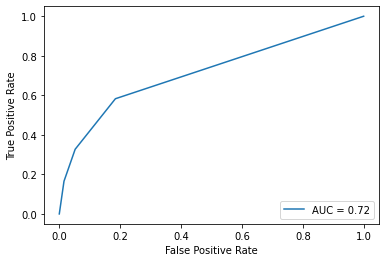

In [20]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()